Tracking of resistance of a resistor with varying temperature

In [1]:
using Plots
using Random
using DifferentialEquations

rng = Xoshiro(14588); # set random number generator seed

Consider a simple ODE of a resistor's temperature $\vartheta(t)$
$$\frac{\mathrm{d}}{\mathrm{d}t}\vartheta(t)=\frac{1}{C_{\mathrm{th}}}\left(\frac{\vartheta_{\mathrm{A}}(t)-\vartheta(t)}{{R_\mathrm{th}}}+P(t)\right)$$
with the ambient temperature $\vartheta_{\mathrm{A}}(t)$, the thermal capacity $C_{\mathrm{th}}$, the thermal resistance $R_{\mathrm{th}}$ and the power $P(t)$. The latter is 
$$P(t) = R(t)i^2(t)$$ 
with the current $i(t)$ and the ohmic resistance $R(t)$ which is considered linearly dependent on the temperature
$$R(t) = R_0\left[1+\alpha\left(\vartheta(t)-\vartheta_0\right)\right]$$
with the reference resistance $R_0$, the reference temperature $\vartheta_0$ and the temperature coefficient of resistance $\alpha$.

Lets model this non-linear ODE using DifferentialEquations.jl.

In [2]:
#  Set up a dynamic simulation model of a resistor which is heated up by a current.

# p[1] = C_th, thermal capacitance of the resistor in J/K
# p[2] = R_th, thermal resistance of the resistor in K/W
# p[3] = ϑ_A, ambient temperature in °C
# p[4] = R_0, resistance at ambient temperature in Ohm
# p[5] = alpha, temperature coefficient of resistance in 1/°C
# p[6] = i_load(t), load current function of time t in A

resistance(x,p) = p[4].*(1 .+ p[5].*(x .- p[3])) # linear temperature-to-resistance model

function resistor_heating(dx, x, p, t)
    dx[1] = 1/p[1] * ((p[3] - x[1])/p[2] + resistance(x[1],p) * p[6](t) ^2) # Temperature ODE
end

resistor_heating (generic function with 1 method)

Assume a sinusoidal load current $i(t) = 10\,\mathrm{A}\cdot(\sin{t})$

In [3]:
i_load = t -> 10 .* sin(t)

#9 (generic function with 1 method)

Formulate ODE problem and solve it using DifferentialEquations.jl package. 

The solution is reported on a discrete-time grid with $\Delta t = 0.05 \,\mathrm{s}$, i.e., we receive a solution for $k=1,2,\ldots$ sampling points.

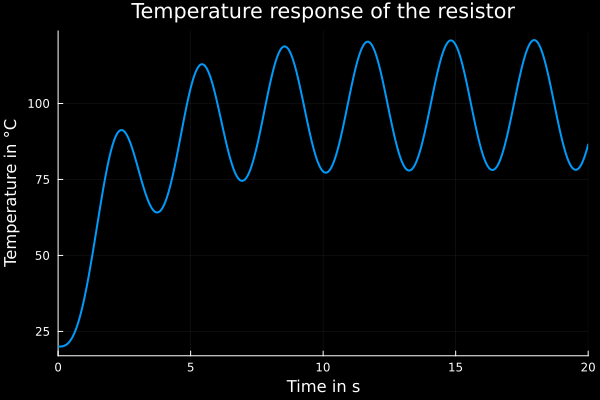

In [4]:
# [C_th, R_th, vartheta_A, R_0, alpha, load current, resistance function]
p = [3.0, 0.6, 20.0, 2.0, 3.93e-3, i_load, resistance] # parameter vector 

tspan = (0.0, 20.0) # Time span
x0 = [20.0] # Starting temperature

prob = ODEProblem(resistor_heating, x0, tspan, p) # Set up the ODE problem
sol = solve(prob, RK4(), saveat=0.05) # Solve the ODE problem and store results every 0.05 seconds
plot(sol, xlabel="Time in s", ylabel="Temperature in °C", 
title="Temperature response of the resistor", legend=false, lw=2,
background_color="#000000", foregroundcolourgrid=:white, grid=true) # plot results



Additionally, we can utilize Ohm's law $$v[k] = i[k]R[k]$$ and its linear dependency of the voltage $v[k]$ on the current $i[k]$ and the resistance $R[k]$ to formulate a linear regression problem. As the Ohm's law is a static model and if we assume that the temperature change over time is sufficiently slow, we can use the recursive linear regression to estimate the resistance $R[k]$ at each time instant $k$. 

Lets prepare the scalar regression problem for the resistance with $y[k] = z[k]w[k]$ with $y$ being the noisy voltage over the resistor, $z$ being the current and $w$ being the resistance.

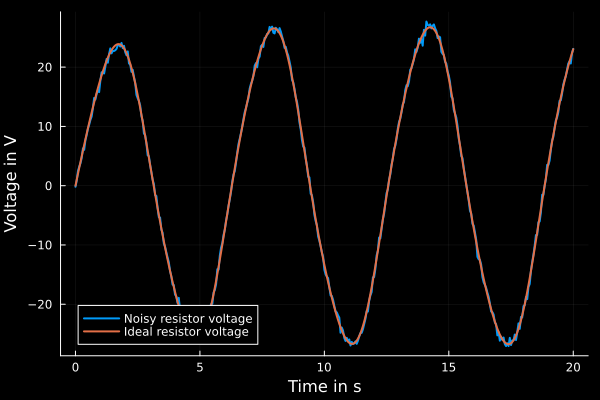

In [8]:
R = resistance(sol[1,:], p) # Extract resistance values based on simulated temperature response
v = i_load.(sol.t) .* R # Calculate voltage over resistor based on load current and resistance

Y = v + randn(length(v)) .* 0.5 # Add measurement noise to the voltage signal

plot(sol.t, Y, xlabel="Time in s", ylabel="Voltage in V", lw=2,
label="Noisy resistor voltage", background_color="#000000", 
foregroundcolourgrid=:white, grid=true)
plot!(sol.t, v, xlabel="Time in s", ylabel="Voltage in V", lw=2,
label="Ideal resistor voltage", background_color="#000000", 
foregroundcolourgrid=:white, grid=true)

Set up the recursive least squares (RLS) estimator with exponential forgetting to track the resistance.

In [9]:
w = zeros(length(sol.t)) # Initialize the parameter vector
w[1] = p[4] # Set initial value of R_0
P = 0.05 .* ones(length(sol.t)) # Initialize the covariance
γ = zeros(length(sol.t)) # Initialize the gain
z = i_load.(sol.t) # Set the regresspr vector
λ = 0.99 # Set the forgetting factor
for k = 2:length(sol.t) # Iterate over all time steps
    γ[k] = P[k-1]*z[k]/(λ+z[k]*P[k-1]*z[k]) # Calculate the gain
    P[k] = (1-γ[k]*z[k])*P[k]/λ # Update the covariance
    w[k] = w[k-1] + γ[k]*(Y[k]-z[k]*w[k-1]) # Update the parameter vector
end

Plot the parameter estimation result.

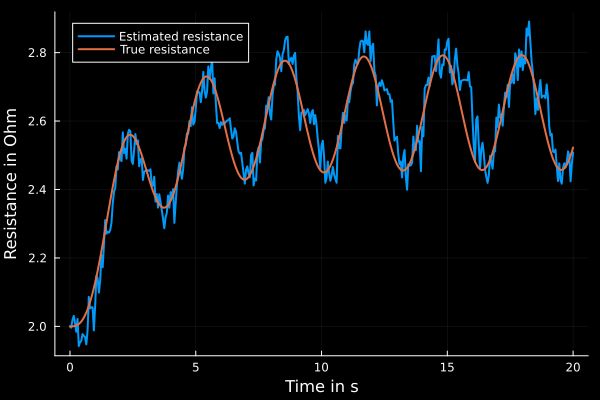

In [10]:
plot(sol.t, w, xlabel="Time in s", ylabel="Resistance in Ohm", 
label="Estimated resistance", lw=2, background_color="#000000", 
foregroundcolourgrid=:white, grid=true)
plot!(sol.t, R, xlabel="Time in s", ylabel="Resistance in Ohm", 
label="True resistance", lw=2, background_color="#000000", 
foregroundcolourgrid=:white, grid=true)